# Modelling and Tuning
In this notebook, we model with the pre-processed datasets and determine the production model.

Contents:
- [Imports](#Import-libraries-and-data)
- [Model preprocessing and preparation](#Model-preprocessing-and-preparation)
- [Model evaluation and selection](#Model-evaluation-and-selection)


### Import libraries and data

In [188]:
# import libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from prettytable import PrettyTable
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import sys
from sklearn.feature_selection import chi2, SelectKBest
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
!{sys.executable} -m pip install mlens
from mlens.ensemble import SuperLearner

In [305]:
# import train and test set
train = pd.read_csv("../data/clean/train_processed.csv")
test = pd.read_csv("../data/clean/test_processed.csv")

In [306]:
# preview dataset
display(train.head())
print("Shape of train set: ", train.shape)
display(test.head())
print("Shape of test set: ", test.shape)

,nummosquitos,cool_7,heat_10,species_CULEX PIPIENS,weekofyear,dewpoint_10,species_CULEX RESTUANS,wnvpresent
0,1,1.714286,1.8,0,22,50.3,0,0
1,1,1.714286,1.8,0,22,50.3,1,0
2,1,1.714286,1.8,0,22,50.3,1,0
3,1,1.714286,1.8,0,22,50.3,0,0
4,4,1.714286,1.8,0,22,50.3,1,0


Shape of train set:  (8475, 8)


,nummosquitos,cool_7,heat_10,species_CULEX PIPIENS,weekofyear,dewpoint_10,species_CULEX RESTUANS,id
0,14.0,7.0,0.0,0,24,64.4,0,1
1,14.0,7.0,0.0,0,24,64.4,1,2
2,14.0,7.0,0.0,1,24,64.4,0,3
3,14.0,7.0,0.0,0,24,64.4,0,4
4,14.0,7.0,0.0,0,24,64.4,0,5


Shape of test set:  (116293, 8)


In [307]:
# change number of moduitoes as integers
test['nummosquitos'].astype(int)

0         14
1         14
2         14
3         14
4         14
          ..
116288     7
116289     7
116290     7
116291     7
116292     7
Name: nummosquitos, Length: 116293, dtype: int32

In [308]:
# check difference in columns
train_cols = train.columns
test_cols = test.columns
train_not_test = train_cols.difference(test_cols)
print(train_not_test)

Index(['wnvpresent'], dtype='object')


In [309]:
#drop test id
test.drop(columns = 'id', inplace = True)
# view shape
print("Shape of train set: ", train.shape)
print("Shape of test set: ", test.shape)

Shape of train set:  (8475, 8)
Shape of test set:  (116293, 7)


### Model preprocessing and preparation
As we have an imbalanced classification on the training set, we will apply an oversampling technique called Adaptive Synthetic (ADASYN) to balance the class. With ADASYN, new samples are synthesized from the minority class, as opposed to merely duplicating the minority samples (Bhattacharyya, 2018). This may help reduce overfitting of the model.

In [310]:
# prep the training set
X = train.drop(columns = 'wnvpresent')
y = train.wnvpresent

In [311]:
# split training set into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [312]:
# instantitate and fit, resample
counter_before = Counter(y_train)
print("Count before ADASYN: ", counter_before)
ada = ADASYN(sampling_strategy = 'minority')
X_train,y_train = ada.fit_resample(X_train,y_train)
counter_after = Counter(y_train)
print("Count after ADASYN: ", counter_after)

Count before ADASYN:  Counter({0: 6011, 1: 345})
Count after ADASYN:  Counter({0: 6011, 1: 5982})


Classes are now balanced and we now do model preparation!

### Model evaluation and selection

Here we feed the data into various models and select the best performing model. Following that, we will tune the hyperparameters of the model to further improve the score. 

In selecting the best performing model, there are several metrics to consider in a binary classification problem such as this, which is to tell us whether a particular testing site will have WNV or not. 

**Evaluation Strategy** 

In considering the metrics to evaluate the model, we first look at the types of prediction error we can get (Type 1 error or Type 2 error). 

<u>Type 1 error</u>

This error is the false positive rate (FPR) which is the fraction of false alerts based on model predictions. In relation to the current problem, it would be the model predicting that WNV is present when it actually is not. 

Let's consider the implications of this. From the government's perspective, should there in fact not be a WNV present and spraying efforts were made, it would be an inefficient use of resources. Also, if say people are made aware that their living area indicated presence of WNV, they may purchase mosquito repellants when they don't actually need to. 

<u>Type 2 Error</u>

This error is the false negative rate (FNR) which is the fraction of missed detection based on model predictions. In other words, it would be the model predicting that WNV is not present when it actually is. 

This may breed complacency (pun intended) among residents of the area, whereby they don't find the need to buy mosquito repellants or take any precautions. Should there be a resident in the area diagnosed with WNV, coupled with complacency of residents of the area, this may potentially lead to a WNV epidemic. For the government's perspective, healthcare costs would rise due to this.

From the above two types of error, Type 2 error is more dire than Type 1 error, from a cost perspective. Due to this, our model should seek to minimize false negatives as much as possible, more so than attempting to reduce false positives. 

**Scoring Metrics**

The balance between false positive rates and false negative rates can be seen in the precision-recall trade-off. 

Precision evaluates how precise the model is in predicting positive labels (in this case, WNV presence) and is a good evaluation metric to use when the cost of false positive is higher than the cost of a false negative (Erika, 2019). 

Recall calculates the percentage of actual positives a model correctly identified (ie. true positives) and is a good evaluation metric for when the cost of false negative is higher than that for false positives, which is in our case. 

While recall is more important than precision in our case, we cannot completely neglect precision due to the unnecessary government spending for false positive cases. So recall is more important than precision but not negligible. To assess recall and precision score, we will use the <u>confusion matrix</u> in evaluating our models.

On top of that, we will also assess our model using the <u>ROC-AUC curve</u>. The ROC-AUC curve visualises the trade off between the true-positive rate (TPR) and false-positive rate (FPR) (Czakon, 2019). The better the model, the higher the TPR and the lower the FPR. To evaluate the model in numbers, we find the <u>Area Under Curve (AUC) score</u>. AUC score of 1 means a perfect classification and ideally we want a score closer to 1. This is the scoring metric used in kaggle as well. 

In [313]:
def scale(X_train, X_val_test):
    '''function for standard scaling'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val_test = ss.transform(X_val_test)
    return X_train, X_val_test

In [318]:
def baseline():
    '''function that creates baseline models'''
    pipeline1 = Pipeline([
    ('logreg', LogisticRegression())
    ])
    pipeline2 = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
    ])
    pipeline3 = Pipeline([
    ('rf', RandomForestClassifier())
    ])
    pipeline4 = Pipeline([
    ('ada', AdaBoostClassifier())
    ])
    
    names = ["Logistic Regression", "K-Nearest Neighbours", "Random Forest", "Ada Boost"]
    pipes = [pipeline1, pipeline2, pipeline3, pipeline4]
    
    print("Getting baseline models...")
    for i in range(len(names)):
        print(f"Pipeline : {names[i]}")
        gs = GridSearchCV(pipes[i], param_grid = {}, n_jobs = -1, refit = 'recall')
        gs.fit(X_train, y_train)
        y_pred_train_base = gs.predict(X_train)
        y_pred_val_base = gs.predict(X_val)

        #scores
        acc_train = round(accuracy_score(y_train,y_pred_train_base),3)
        f1_train = round(f1_score(y_train,y_pred_train_base),3)
        precision_train = round(precision_score(y_train,y_pred_train_base),3)    
        recall_train = round(recall_score(y_train,y_pred_train_base),3) 
        rocauc_train = round(roc_auc_score(y_train,y_pred_train_base),3)
        
        acc_val = round(accuracy_score(y_val,y_pred_val_base),3)
        f1_val = round(f1_score(y_val,y_pred_val_base),3)
        precision_val = round(precision_score(y_val,y_pred_val_base),3)    
        recall_val = round(recall_score(y_val,y_pred_val_base),3) 
        rocauc_val = round(roc_auc_score(y_val,y_pred_val_base),3)        
               
        table1 = PrettyTable(title = f'Results of Baseline for Pipeline {i+1} - {names[i]}', header_style = 'title', max_table_width = 115)
        table1.field_names = ["Dataset", "Accuracy score", "F1 score", "Precision score", "Recall score", "ROC-AUC score", "Confusion_Matrix"]
        table1.add_row(["Training Set", acc_train, f1_train, precision_train, recall_train, rocauc_train, confusion_matrix(y_train, y_pred_train_base)])
        table1.add_row(["Validation Set", acc_val, f1_val, precision_val, recall_val, rocauc_val, confusion_matrix(y_val, y_pred_val_base)])
        table1.add_row(["Extent of Overfit", round(acc_train-acc_val,3),round(f1_train-f1_val,3), round(precision_train-precision_val,3), round(recall_train-recall_val,3), round(rocauc_train-rocauc_val,3), " "])
        table1._max_width = {"Confusion_Matrix": 25}
        print(table1)

In [319]:
%%time
baseline()

Getting baseline models...
Pipeline : Logistic Regression
+-------------------------------------------------------------------------------------------------------------------+
|                              Results of Baseline for Pipeline 1 - Logistic Regression                             |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|      Dataset      | Accuracy Score | F1 Score | Precision Score | Recall Score | Roc-Auc Score | Confusion_Matrix |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|    Training Set   |      0.77      |  0.783   |      0.739      |    0.834     |      0.77     |   [[4246 1765]   |
|                   |                |          |                 |              |               |   [ 996 4986]]   |
|   Validation Set  |      0.69      |  0.202   |      0.117      |    0.741     |     0.714     |   [[1379  628]   

In [334]:
def grid_search():
    '''function that finds the best hyperparameters for each model'''
    pipeline1 = Pipeline([
    ('logreg', LogisticRegression())
    ])
    pipeline2 = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
    ])
    pipeline3 = Pipeline([
    ('rf', RandomForestClassifier())
    ])
    pipeline4 = Pipeline([
    ('ada', AdaBoostClassifier())
    ])
    
    params1 = {
        'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'logreg__penalty': ['l2'],
        'logreg__C': [10, 1.0, 0.1, 0.01]
    }
    params2 = {
        'knn__n_neighbors': [1, 10, 50],
        'knn__leaf_size': [1, 20, 40]
    }
    params3 = {
        'rf__n_estimators':[10, 20, 30, 50, 100, 500],
        'rf__max_depth':[None, 1, 3],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__criterion': ['gini', 'entropy'],
        'rf__min_samples_split': [5,10,20],
        'rf__min_samples_leaf': [5,10,20]
    }
    params4 = {
        'ada__n_estimators':[700, 900, 1100, 1500, 2000],
        'ada__learning_rate': [0.01, 0.3, 0.6]
    }
    
    names = ["Logistic Regression", "K-Nearest Neighbours", "Random Forest", "Ada Boost"]
    params = [params1, params2, params3, params4]
    pipes = [pipeline1, pipeline2, pipeline3, pipeline4]  
    
    print("GridSearch starting...")
    best_params = []
    for j in range(len(params)):
        print(f"Pipeline : {names[j]}")
        gs = GridSearchCV(pipes[j], params[j], n_jobs = -1, refit = 'recall')
        gs.fit(X_train, y_train)
        y_pred_train = gs.best_estimator_.predict(X_train)
        y_pred_val = gs.best_estimator_.predict(X_val)
        best_params.append(gs.best_params_)
        
        #scores
        acc_train = round(accuracy_score(y_train,y_pred_train),3)
        f1_train = round(f1_score(y_train,y_pred_train),3)
        precision_train = round(precision_score(y_train,y_pred_train),3)    
        recall_train = round(recall_score(y_train,y_pred_train),3) 
        rocauc_train = round(roc_auc_score(y_train,y_pred_train),3)
        
        acc_val = round(accuracy_score(y_val,y_pred_val),3)
        f1_val = round(f1_score(y_val,y_pred_val),3)
        precision_val = round(precision_score(y_val,y_pred_val),3)    
        recall_val = round(recall_score(y_val,y_pred_val),3) 
        rocauc_val = round(roc_auc_score(y_val,y_pred_val),3)        
               
        table3 = PrettyTable(title = f'Results of Pipeline {j+1} - {names[j]}', header_style = 'title', max_table_width = 115)
        table3.field_names = ["Dataset", "Accuracy score", "F1 score", "Precision score", "Recall score", "ROC-AUC score", "Confusion_Matrix"]
        table3.add_row(["Training Set", acc_train, f1_train, precision_train, recall_train, rocauc_train, confusion_matrix(y_train, y_pred_train)])
        table3.add_row(["Validation Set", acc_val, f1_val, precision_val, recall_val, rocauc_val, confusion_matrix(y_val, y_pred_val)])
        table3.add_row(["Extent of Overfit", round(acc_train-acc_val,3),round(f1_train-f1_val,3), round(precision_train-precision_val,3), round(recall_train-recall_val,3), round(rocauc_train-rocauc_val,3), " "])
        table3._max_width = {"Confusion_Matrix": 25}
        print(table3)
                 
    table2 = PrettyTable(title = "Best Parameters", header_style = 'title', max_table_width = 115)
    table2.field_names = ["Classifier", "Params"]
    table2.add_row([names[0], best_params[0]])
    table2.add_row([names[1], best_params[1]])
    table2.add_row([names[2], best_params[2]])    
    table2.add_row([names[3], best_params[3]])    
    print(table2)

In [335]:
%%time
grid_search()

GridSearch starting...
Pipeline : Logistic Regression
+-------------------------------------------------------------------------------------------------------------------+
|                                    Results of Pipeline 1 - Logistic Regression                                    |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|      Dataset      | Accuracy Score | F1 Score | Precision Score | Recall Score | Roc-Auc Score | Confusion_Matrix |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|    Training Set   |     0.768      |   0.78   |      0.741      |    0.823     |     0.769     |   [[4293 1718]   |
|                   |                |          |                 |              |               |   [1059 4923]]   |
|   Validation Set  |     0.701      |  0.211   |      0.123      |    0.759     |     0.728     |   [[1400  607]   |
| 

There seems to be overfitting across all models. Looking at the roc_auc score and the recall score, the best model is the `Ada Boost`. We will proceed to further tune the model below to get a better recall and roc_auc score. 

#### Ada Boost Classifier
Here we tune the hyperparameters of `AdaBoost` so we can get a better `roc-auc` score. 

In [336]:
#results on train/val set 
def results_trainval(X_train,y_train,X_val,model,name):
    '''function outputs predictions on val set for training set run on model'''
    model.fit(X_train,y_train)
    preds_4 = model.predict(X_train)
    preds_5 = model.predict(X_val)
    
    #scores
    acc_train = round(accuracy_score(y_train,preds_4),3)
    f1_train = round(f1_score(y_train,preds_4),3)
    precision_train = round(precision_score(y_train,preds_4),3)    
    recall_train = round(recall_score(y_train,preds_4),3) 
    rocauc_train = round(roc_auc_score(y_train,preds_4),3)

    acc_val = round(accuracy_score(y_val,preds_5),3)
    f1_val = round(f1_score(y_val,preds_5),3)
    precision_val = round(precision_score(y_val,preds_5),3)    
    recall_val = round(recall_score(y_val,preds_5),3) 
    rocauc_val = round(roc_auc_score(y_val,preds_5),3)      
    
    table = PrettyTable(title = f'Results of {name} on Train and Validation Set', header_style = 'title', max_table_width = 115)
    table.field_names = [" ", "Accuracy Score", "F1 score", "Precision score", "Recall score", "ROC-AUC score", "Confusion_Matrix"]
    table.add_row(["Training Set", acc_train, f1_train, precision_train, recall_train, rocauc_train, confusion_matrix(y_train, preds_4)])
    table.add_row(["Validation Set", acc_val, f1_val, precision_val, recall_val, rocauc_val, confusion_matrix(y_val, preds_5)])
    table.add_row(["Extent of Overfit", round(acc_train-acc_val,3),round(f1_train-f1_val,3), round(precision_train-precision_val,3), round(recall_train-recall_val,3), round(rocauc_train-rocauc_val,3), " "])
    table._max_width = {"Confusion_Matrix": 25}
    print(table)

    return preds_5

In [337]:
#results on full training set 
def results(X,y,test,model,name):
    '''function outputs predictions on test set for full training set run on model'''
    model.fit(X,y)
    preds_4 = model.predict(X)
    preds_5 = model.predict(test)
    
    table = PrettyTable(title = f'Results of {name} on Full Training Set', header_style = 'title', max_table_width = 115)
    table.field_names = [" ", "Accuracy Score", "F1 score", "Precision score", "Recall score", "ROC-AUC score", "Confusion_Matrix"]
    table.add_row(["Full Training Set", round(accuracy_score(y,preds_4),3), round(f1_score(y,preds_4),3), round(precision_score(y,preds_4),3), round(recall_score(y,preds_4),3), round(roc_auc_score(y,preds_4),3),confusion_matrix(y,preds_4)])
    print(table)

    return preds_5

In [363]:
ada = AdaBoostClassifier()
params4 = {
    'n_estimators':[700, 900, 1100, 1500],
    'learning_rate': [0.001, 0.01, 0.3, 0.6]
}

In [371]:
gs_ada = GridSearchCV(ada, params4, n_jobs = -1, cv = 5, refit = 'roc_auc')
preds_6 = results_trainval(X_train,y_train,X_val,gs_ada, "Ada Boost")
print("Best Parameters :", gs_ada.best_params_)

+-------------------------------------------------------------------------------------------------------------------+
|                                  Results of Ada Boost on Train and Validation Set                                 |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|                   | Accuracy Score | F1 Score | Precision Score | Recall Score | Roc-Auc Score | Confusion_Matrix |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|    Training Set   |      0.91      |  0.911   |      0.901      |     0.92     |      0.91     |   [[5405  606]   |
|                   |                |          |                 |              |               |   [ 476 5506]]   |
|   Validation Set  |     0.869      |  0.312   |      0.216      |    0.562     |     0.724     |   [[1778  229]   |
|                   |                |          |       

See how it generalises across the full training set. 

In [369]:
%%time
params4 = {
    'n_estimators':[1500],
    'learning_rate': [1.0]
}
gs_ada = GridSearchCV(ada, params4, n_jobs = -1, cv = 5, refit = 'roc_auc')
preds_6 = results(X,y,test,gs_ada, "Ada Boost")

+-------------------------------------------------------------------------------------------------------------------+
|                                     Results of Ada Boost on Full Training Set                                     |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|                   | Accuracy Score | F1 Score | Precision Score | Recall Score | Roc-Auc Score | Confusion_Matrix |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
| Full Training Set |     0.951      |  0.329   |      0.643      |    0.221     |     0.607     |   [[7962   56]   |
|                   |                |          |                 |              |               |   [ 356  101]]   |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
Wall time: 23.4 s


It appears that the model is an overfit, although with tuning.

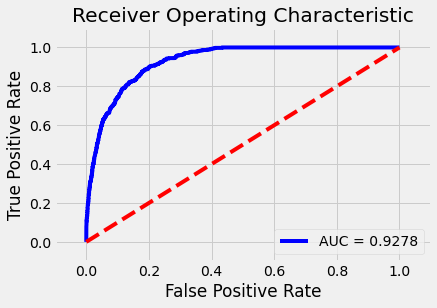

In [370]:
# calculate the fpr and tpr for all thresholds of the classification
probs = gs_ada.predict_proba(X)
preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.10, 1.1])
plt.ylim([-0.10, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [118]:
# # kaggle submission file
# test_proc = pd.read_csv("../data/clean/test_processed.csv")
# submission = pd.DataFrame({"id": test_proc.id.values})
# submission["WnvPresent"] = preds_6
# submission.to_csv("../kaggle-submissions/kaggle_submission_12.csv", index=False)

### Super Learner
We have run through grid searching for the best hyperparameters above. We also consider using a super learner. The super learner is an ensemble machine learning algorithm that combines all of the models and model configurations that we have investigated and uses them to make a prediction as-good-as or better than any single model that you may have investigated (Brownlee, 2020).

In [239]:
# instantiate models 
logreg = LogisticRegression()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()

In [240]:
# build ensemble model
def build_ensemble(incl_meta, proba, propagate_features=[0,1]):
    '''function returns an ensemble'''
    if propagate_features:
        n = len(propagate_features)
        propagate_features_1 = propagate_features
        propagate_features_2 = [i for i in range(n)]
    else:
        propagate_features_1 = propagate_features_2 = None
        
    estimators_layer1 = [logreg]
    estimators_layer2 = [knn]
    estimators_layer3 = [rf]
    estimators_layer4 = [ada]
    
    ensemble = SuperLearner()
    ensemble.add(estimators_layer1, proba = proba, propagate_features = propagate_features)
    ensemble.add(estimators_layer2, proba = proba, propagate_features = propagate_features)
    ensemble.add(estimators_layer3, proba = proba, propagate_features = propagate_features)
    ensemble.add(estimators_layer4, proba = proba, propagate_features = propagate_features)
    
    if incl_meta:
        ensemble.add_meta(logreg)
        
        return ensemble

In [241]:
# function that runs and evaluate ensembled model
def run_model(X_train, y_train, X_val, y_val, model):
    model.fit(X_train, y_train)
    preds_0 = model.predict(X_train)
    preds_1 = model.predict(X_val)    

        #scores
    acc_train = round(accuracy_score(y_train,preds_0),3)
    f1_train = round(f1_score(y_train,preds_0),3)
    precision_train = round(precision_score(y_train,preds_0),3)    
    recall_train = round(recall_score(y_train,preds_0),3) 
    rocauc_train = round(roc_auc_score(y_train,preds_0),3)

    acc_val = round(accuracy_score(y_val,preds_1),3)
    f1_val = round(f1_score(y_val,preds_1),3)
    precision_val = round(precision_score(y_val,preds_1),3)    
    recall_val = round(recall_score(y_val,preds_1),3) 
    rocauc_val = round(roc_auc_score(y_val,preds_1),3)    

    table = PrettyTable(title = 'Results of Ensemble on Train and Validation Set', header_style = 'title', max_table_width = 115)
    table.field_names = [" ", "Accuracy Score", "F1 score", "Precision score", "Recall score", "ROC-AUC score", "Confusion_Matrix"]
    table.add_row(["Training Set", acc_train, f1_train, precision_train, recall_train, rocauc_train, confusion_matrix(y_train,preds_0)])
    table.add_row(["Validation Set", acc_val, f1_val, precision_val, recall_val, rocauc_val, confusion_matrix(y_val,preds_1)])
    table.add_row(["Extent of Overfit", round(acc_train-acc_val,3),round(f1_train-f1_val,3), round(precision_train-precision_val,3), round(recall_train-recall_val,3), round(rocauc_train-rocauc_val,3), " "])
    table._max_width = {"Confusion_Matrix": 25}
    print(table)
    
    return preds_1

In [242]:
# run the model
X_train, X_val = scale(X_train, X_val) #scale
model = build_ensemble(True, True)
preds_1 = run_model(X_train, y_train, X_val, y_val, model)

+-------------------------------------------------------------------------------------------------------------------+
|                                  Results of Ensemble on Train and Validation Set                                  |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|                   | Accuracy Score | F1 Score | Precision Score | Recall Score | Roc-Auc Score | Confusion_Matrix |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|    Training Set   |     0.643      |  0.569   |      0.721      |    0.469     |     0.644     |   [[4916 1095]   |
|                   |                |          |                 |              |               |   [3198 2829]]   |
|   Validation Set  |     0.791      |   0.21   |      0.131      |    0.527     |     0.666     |   [[1617  390]   |
|                   |                |          |       

In [244]:
# run on full training set
def run_model_test(X,y,test,model):
    model.fit(X,y)
    preds_3 = model.predict(test)
    preds_2 = model.predict(X)
    
    table = PrettyTable(title = 'Results of Ensemble on Full Training Set', header_style = 'title', max_table_width = 115)
    table.field_names = [" ", "Accuracy score", "F1 score", "Precision score", "Recall score", "ROC-AUC score", "Confusion_Matrix"]
    table.add_row(["Full Training Set", round(accuracy_score(y,preds_2),3), round(f1_score(y,preds_2),3), round(precision_score(y,preds_2),3), round(recall_score(y,preds_2),3), round(roc_auc_score(y,preds_2),3),confusion_matrix(y,preds_2)])
    print(table)

    return preds_3

In [245]:
# run model on full training set
X, test = scale(X, test)
model = build_ensemble(True, True)
preds_3 = run_model_test(X,y,test,model)

+-------------------------------------------------------------------------------------------------------------------+
|                                      Results of Ensemble on Full Training Set                                     |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
|                   | Accuracy Score | F1 Score | Precision Score | Recall Score | Roc-Auc Score | Confusion_Matrix |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+
| Full Training Set |     0.947      |  0.093   |      0.622      |     0.05     |     0.524     |   [[8004   14]   |
|                   |                |          |                 |              |               |   [ 434   23]]   |
+-------------------+----------------+----------+-----------------+--------------+---------------+------------------+


There is a chance that the superlearner is overfitted as the best hyperparameters of the models in this ensemble are being used, resulting in a less than optimal performance, when applied on the validation set. 

In [125]:
# Create_submission file
# test_proc = pd.read_csv("../data/clean/test_processed.csv")
# submission = pd.DataFrame({"id": test_proc.id.values})
# submission["WnvPresent"] = preds_3
# submission.to_csv("../kaggle-submissions/kaggle_submission_15.csv", index=False)

Seems like the ensemble method did not do any better than `AdaBoost` so we will move forward with `Adaboost`.

### Interpret results
Our selected production model is `AdaBoost` classifier as it was able to generalise well.

![](../images/ada.JPG)

Based on this model, we note the following based on the scores: 

<u>Precision (TP/(TP+FP))</u>

Our model can predict WNV presence correctly 90.1% of the time, where  9.9% of positive predictions are false positives (ie. predicting that WNV is present when it actually is not). While we want to minimize false positives due to the costs incurred for spraying efforts, we want to prioritise minimising false negatives, which can be seen in the recall. 


<u>Recall (TP/(TP+FN)) or True Positive Rate (TPR)</u>


Our model is able to predict actual positives 92% of the time, where the 8% of predictions are false negatives (ie. predicting that WNV is not present when it actually is). Our model did well in minimizing false negatives more than false positives. 

<u>ROC-AUC score</u>

The trade-off betwen the true-positive rate and the false-positive rate (ie. probability of false alarm) is visualised in the ROC-AUC curve below, which shows that 91% of the time, the model is able to classify correctly the presence of WNVV or not. 

### References

"SMOTE and ADASYN ( Handling Imbalanced Data Set )" (Bhattacharyya, 2018)
https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167

"How to Develop Super Learner Ensembles in Python" (Brownlee, 2020)
https://machinelearningmastery.com/super-learner-ensemble-in-python/